# Resampling and Modelling

# Introduction

Here I will create feature variables for use with the logistic regression model to create a baseline performance for predicting CTR on Google AdWords data.

First the data will need to be either weighted or resampled to remove class imbalance. Teh class imbalance is not too severe from first impressions.

Then the mdoels will be evaluated and tuned to get the best performance for the various machin learning models so that thety can then be used as measures against more deep learning methods that perhaps will be able to capture any non-linear coefficients that the data may exhibit. 

Various evaluation techniques will be used based around the principles of recall, precision and accuracy


# Load Data

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, matthews_corrcoef, brier_score_loss, log_loss
import scikitplot as skplt
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.metrics import *
from category_encoders.ordinal import OrdinalEncoder
%matplotlib inline

In [460]:
import pandas as pd
# train_data = pd.read_csv('../data/raw/train_data_no_text.csv', 
#                         parse_dates=['Date'])

train_data = pd.read_csv('../data/raw/train_data_with_text.csv', 
                        parse_dates=['Date'])

In [461]:
train_data.head()

,Unnamed: 0,Ad ID,Ad group ID,Campaign ID,Keyword ID,Search keyword,Search term,Headline 1,Headline 2,Description,...,Landing page experience,Avg. position,Impressions,Clicks,Cost,Conversions,click_target,ctr,Month,Day of Month
0,2,240574173732,46762781465,908117249,315876353270,+cycle +scheme,cycle scheme shops,Save on Bikes and Accessories,With Cyclescheme,Save 25-39% on a Bike and Accessories with Cyc...,...,--,1.0,1,0,0.00,0.0,0,0.0,2,25
1,3,254981712471,61122547628,1077017916,315409030296,+cyclescheme +shops,cycle scheme shops,Buy Bikes & Accessories,Shops Offering CycleScheme,"Use Evans Cycles and 2,000 other shops. Save 2...",...,--,1.0,1,1,0.54,0.0,1,1.0,3,19
2,4,255003718477,61122547628,1077017916,315409030296,+cyclescheme +shops,cycle scheme shops,Bikes & Accessories,Shops Offering CycleScheme,"Use Evans Cycles and 2,000 other retailers. Sa...",...,--,1.0,1,0,0.00,0.0,0,0.0,3,20
3,5,254981712471,61122547628,1077017916,315409030296,+cyclescheme +shops,cycle scheme shops,Buy Bikes & Accessories,Shops Offering CycleScheme,"Use Evans Cycles and 2,000 other shops. Save 2...",...,--,2.0,1,0,0.00,0.0,0,0.0,3,28
4,6,255003718477,61122547628,1077017916,315409030296,+cyclescheme +shops,cycle scheme shops,Bikes & Accessories,Shops Offering CycleScheme,"Use Evans Cycles and 2,000 other retailers. Sa...",...,--,1.0,1,0,0.00,0.0,0,0.0,3,28


In [462]:
train_data.columns

Index(['Unnamed: 0', 'Ad ID', 'Ad group ID', 'Campaign ID', 'Keyword ID',
       'Search keyword', 'Search term', 'Headline 1', 'Headline 2',
       'Description', 'Expanded text ad description 2', 'Path 1', 'Path 2',
       'Ad group', 'Campaign', 'Search term match type', 'Date', 'Day of week',
       'Device', 'Quality score', 'Expected click-through rate',
       'Ad relevance', 'Keyword max CPC', 'First position CPC',
       'Top of page CPC', 'Landing page experience', 'Avg. position',
       'Impressions', 'Clicks', 'Cost', 'Conversions', 'click_target', 'ctr',
       'Month', 'Day of Month'],
      dtype='object')

In [463]:
# for drop text based features
train_data.drop(columns=['Unnamed: 0', 'Ad group ID', 'Conversions'], inplace=True)

In [464]:
train_data.head()

,Ad ID,Campaign ID,Keyword ID,Search keyword,Search term,Headline 1,Headline 2,Description,Expanded text ad description 2,Path 1,...,Top of page CPC,Landing page experience,Avg. position,Impressions,Clicks,Cost,click_target,ctr,Month,Day of Month
0,240574173732,908117249,315876353270,+cycle +scheme,cycle scheme shops,Save on Bikes and Accessories,With Cyclescheme,Save 25-39% on a Bike and Accessories with Cyc...,--,Cycle_Scheme,...,0.06,--,1.0,1,0,0.00,0,0.0,2,25
1,254981712471,1077017916,315409030296,+cyclescheme +shops,cycle scheme shops,Buy Bikes & Accessories,Shops Offering CycleScheme,"Use Evans Cycles and 2,000 other shops. Save 2...",--,Shops,...,0.04,--,1.0,1,1,0.54,1,1.0,3,19
2,255003718477,1077017916,315409030296,+cyclescheme +shops,cycle scheme shops,Bikes & Accessories,Shops Offering CycleScheme,"Use Evans Cycles and 2,000 other retailers. Sa...",--,Shops,...,0.04,--,1.0,1,0,0.00,0,0.0,3,20
3,254981712471,1077017916,315409030296,+cyclescheme +shops,cycle scheme shops,Buy Bikes & Accessories,Shops Offering CycleScheme,"Use Evans Cycles and 2,000 other shops. Save 2...",--,Shops,...,0.04,--,2.0,1,0,0.00,0,0.0,3,28
4,255003718477,1077017916,315409030296,+cyclescheme +shops,cycle scheme shops,Bikes & Accessories,Shops Offering CycleScheme,"Use Evans Cycles and 2,000 other retailers. Sa...",--,Shops,...,0.04,--,1.0,1,0,0.00,0,0.0,3,28


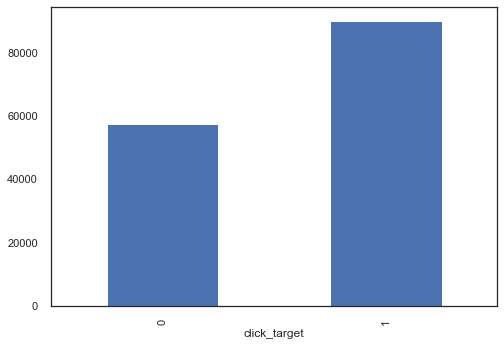

In [465]:
# a quick glance at class balance
train_data.groupby('click_target').size().plot(kind = 'bar')

As mentioned in the introduction, there is class imbalance this will need to tbe fixed before modelling. The class imbalance however is not too severe, so class weight methods could be used in place of resampling.

# Pre-Processing

In [389]:
# check for any NaN
print(train_data.isna().values.sum())

0


In [390]:
train_data.columns[train_data.isna().any()].tolist()

[]

## Create new features from time

In [391]:
train_data['Day of Year'] = train_data['Date'].dt.dayofyear
train_data['Week of Year'] = train_data['Date'].dt.week
train_data['Day of Week'] = train_data['Date'].dt.dayofweek
# drop redundant string version of day
train_data.drop(columns='Day of week', inplace=True)

## Replace '--' in AdWords Data

In [392]:
# replace '--' with NaN
train_data = train_data.replace({'--': np.nan}, regex=True)

In [393]:
# remove all entries with NaN
train_data = train_data.dropna()

In [394]:
# check for any NaN
print(train_data.isna().values.sum())

0


In [395]:
# take one value for sense checking
train_data.head()

,Ad ID,Campaign ID,Keyword ID,Search keyword,Search term,Headline 1,Headline 2,Description,Expanded text ad description 2,Path 1,...,Impressions,Clicks,Cost,click_target,ctr,Month,Day of Month,Day of Year,Week of Year,Day of Week
17,314179204055,1376524026,315409030296,+cyclescheme +shops,cycle scheme shops,Cyclescheme,Find Retailers Near You,"Choose from 2,000 retailers - in-store, online...",Ever-changing mix of best-in-market bike deals...,Cycle-to-Work,...,1,1,0.19,1,1.0,7,12,193,28,4
19,314179204055,1376524026,315409030296,+cyclescheme +shops,cycle scheme shops,Cyclescheme,Find Retailers Near You,"Choose from 2,000 retailers - in-store, online...",Ever-changing mix of best-in-market bike deals...,Cycle-to-Work,...,1,0,0.00,0,0.0,7,22,203,30,0
45,314179204055,1376524026,315409030296,+cyclescheme +shops,cycle scheme shops,Cyclescheme,Find Retailers Near You,"Choose from 2,000 retailers - in-store, online...",Ever-changing mix of best-in-market bike deals...,Cycle-to-Work,...,1,0,0.00,0,0.0,11,26,330,48,0
46,314179204058,1376524026,315409030296,+cyclescheme +shops,cycle scheme shops,Cyclescheme,"Over 2,000 Retailers In The UK",Get any bike & accessories tax free with Cycle...,Ever-changing mix of best-in-market bike deals...,Cycle-to-Work,...,1,0,0.00,0,0.0,12,3,337,49,0
52,314179204055,1376524026,315409030296,+cyclescheme +shops,cycle scheme shops,Cyclescheme,Find Retailers Near You,"Choose from 2,000 retailers - in-store, online...",Ever-changing mix of best-in-market bike deals...,Cycle-to-Work,...,1,1,0.07,1,1.0,1,30,30,5,2


## Create Category Data from Object Data

In [396]:
# list of text wor2vec columns for later
word2vec_cols = ['Search keyword', 'Search term', 'Headline 1', 'Headline 2', 'Description', 'Expanded text ad description 2',
 'Path 1',
 'Path 2',]

In [397]:
word2vec_data = train_data[word2vec_cols]

In [398]:
# create category df
cat_df = train_data.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

In [399]:
# remove object columns
train_data_obj = train_data.select_dtypes(exclude=['object'])

In [400]:
# concat new cat columns
train_data = pd.concat([train_data_obj, cat_df], axis=1)

In [401]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36099 entries, 17 to 147008
Data columns (total 34 columns):
Ad ID                             36099 non-null int64
Campaign ID                       36099 non-null int64
Keyword ID                        36099 non-null int64
Date                              36099 non-null datetime64[ns]
Keyword max CPC                   36099 non-null float64
First position CPC                36099 non-null float64
Top of page CPC                   36099 non-null float64
Avg. position                     36099 non-null float64
Impressions                       36099 non-null int64
Clicks                            36099 non-null int64
Cost                              36099 non-null float64
click_target                      36099 non-null int64
ctr                               36099 non-null float64
Month                             36099 non-null int64
Day of Month                      36099 non-null int64
Day of Year                       36099 non

In [402]:
train_data.shape

(36099, 34)

In [403]:
train_data.reset_index(inplace=True)

In [404]:
train_data.drop(columns=['index'], inplace=True)

In [405]:
train_data.head()

,Ad ID,Campaign ID,Keyword ID,Date,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,...,Path 1,Path 2,Ad group,Campaign,Search term match type,Device,Quality score,Expected click-through rate,Ad relevance,Landing page experience
0,314179204055,1376524026,315409030296,2019-07-12,0.17,0.07,0.03,1.0,1,1,...,Cycle-to-Work,Retailers,Retailers/Online_Cyclescheme,Think-Brand,Exact (close variant),Desktop,10,Above average,Above average,Above average
1,314179204055,1376524026,315409030296,2019-07-22,0.17,0.07,0.03,1.0,1,0,...,Cycle-to-Work,Retailers,Retailers/Online_Cyclescheme,Think-Brand,Exact (close variant),Mobile,10,Above average,Above average,Above average
2,314179204055,1376524026,315409030296,2018-11-26,0.17,0.07,0.03,1.0,1,0,...,Cycle-to-Work,Retailers,Retailers/Online_Cyclescheme,Think-Brand,Exact (close variant),Desktop,10,Above average,Above average,Above average
3,314179204058,1376524026,315409030296,2018-12-03,0.17,0.07,0.03,1.0,1,0,...,Cycle-to-Work,Retailers,Retailers/Online_Cyclescheme,Think-Brand,Exact (close variant),Mobile,10,Above average,Above average,Above average
4,314179204055,1376524026,315409030296,2019-01-30,0.17,0.07,0.03,3.0,1,1,...,Cycle-to-Work,Retailers,Retailers/Online_Cyclescheme,Think-Brand,Exact (close variant),Mobile,10,Above average,Above average,Above average


In [406]:
# drop word2vec cols
train_data.drop(columns=word2vec_cols, inplace=True)

In [407]:
# select these cat columns for later
categorical_columns = list(train_data.select_dtypes(['category']).columns)

In [408]:
categorical_columns

['Ad group',
 'Campaign',
 'Search term match type',
 'Device',
 'Quality score',
 'Expected click-through rate',
 'Ad relevance',
 'Landing page experience']

In [411]:
campaign_cols = categorical_columns[:2]

In [412]:
campaign_cols

['Ad group', 'Campaign']

In [413]:
categorical_columns = categorical_columns[2:]

In [414]:
categorical_columns

['Search term match type',
 'Device',
 'Quality score',
 'Expected click-through rate',
 'Ad relevance',
 'Landing page experience']

In [415]:
train_data.shape

(36099, 26)

## Ordinal Data Encoding

`Quality score`, `Expected clickthrough rate`, `Ad relevance` and `Landing page experience` are all categorical variables that should be encoded as ordered data. The values have inherent information in relation to each other

In [416]:
ordinal_categorical_columns = categorical_columns[2:]

In [417]:
one_hot_categorical_columns = list(categorical_columns[i] for i in [0, 1] )

In [418]:
one_hot_categorical_columns = one_hot_categorical_columns + campaign_cols

In [419]:
one_hot_categorical_columns

['Search term match type', 'Device', 'Ad group', 'Campaign']

In [420]:
ordinal_categorical_columns

['Quality score',
 'Expected click-through rate',
 'Ad relevance',
 'Landing page experience']

In [421]:
ordinal_col_mapping = [{
    "col": "Quality score",
    "mapping": {
        '10': 6,
        '9': 5,
        '8': 4,
        '7': 3,
        '6': 2,
        '5': 1,
        '4': 0
    }}, {
    "col": "Expected click-through rate",
    "mapping": {
        'Above average': 1,
        'Average': 0
    }},
    {
    "col": "Ad relevance",
    "mapping": {
        'Above average': 2,
        'Average': 1,
        'Below average': 0
    }},
    {
    "col": "Landing page experience",
    "mapping": {
        'Above average': 2,
        'Average': 1,
        'Below average': 0
    }}
] 

In [422]:
# create encoder instance
ord_enc = OrdinalEncoder(mapping=ordinal_col_mapping, return_df=True)
ord_enc

OrdinalEncoder(cols=None, drop_invariant=False, handle_missing='value',
               handle_unknown='value',
               mapping=[{'col': 'Quality score',
                         'mapping': {'10': 6, '4': 0, '5': 1, '6': 2, '7': 3,
                                     '8': 4, '9': 5}},
                        {'col': 'Expected click-through rate',
                         'mapping': {'Above average': 1, 'Average': 0}},
                        {'col': 'Ad relevance',
                         'mapping': {'Above average': 2, 'Average': 1,
                                     'Below average': 0}},
                        {'col': 'Landing page experience',
                         'mapping': {'Above average': 2, 'Average': 1,
                                     'Below average': 0}}],
               return_df=True, verbose=0)

## Create New Transformed DF - Train with Orindal Encoding

In [423]:
# fit ordinal encoding and tranform
df_train = ord_enc.fit_transform(train_data)
df_train.head()

,Ad ID,Campaign ID,Keyword ID,Date,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,...,Week of Year,Day of Week,Ad group,Campaign,Search term match type,Device,Quality score,Expected click-through rate,Ad relevance,Landing page experience
0,314179204055,1376524026,315409030296,2019-07-12,0.17,0.07,0.03,1.0,1,1,...,28,4,Retailers/Online_Cyclescheme,Think-Brand,Exact (close variant),Desktop,6,1,2,2
1,314179204055,1376524026,315409030296,2019-07-22,0.17,0.07,0.03,1.0,1,0,...,30,0,Retailers/Online_Cyclescheme,Think-Brand,Exact (close variant),Mobile,6,1,2,2
2,314179204055,1376524026,315409030296,2018-11-26,0.17,0.07,0.03,1.0,1,0,...,48,0,Retailers/Online_Cyclescheme,Think-Brand,Exact (close variant),Desktop,6,1,2,2
3,314179204058,1376524026,315409030296,2018-12-03,0.17,0.07,0.03,1.0,1,0,...,49,0,Retailers/Online_Cyclescheme,Think-Brand,Exact (close variant),Mobile,6,1,2,2
4,314179204055,1376524026,315409030296,2019-01-30,0.17,0.07,0.03,3.0,1,1,...,5,2,Retailers/Online_Cyclescheme,Think-Brand,Exact (close variant),Mobile,6,1,2,2


In [424]:
df_train.columns

Index(['Ad ID', 'Campaign ID', 'Keyword ID', 'Date', 'Keyword max CPC',
       'First position CPC', 'Top of page CPC', 'Avg. position', 'Impressions',
       'Clicks', 'Cost', 'click_target', 'ctr', 'Month', 'Day of Month',
       'Day of Year', 'Week of Year', 'Day of Week', 'Ad group', 'Campaign',
       'Search term match type', 'Device', 'Quality score',
       'Expected click-through rate', 'Ad relevance',
       'Landing page experience'],
      dtype='object')

In [425]:
df_train.shape

(36099, 26)

## One-Hot Encoding

In [426]:
# get dummies encoding                                                                      
df_train = pd.concat([df_train, pd.get_dummies(df_train[one_hot_categorical_columns])], axis=1)

In [427]:
# drop transformed columns
df_train.drop(columns=one_hot_categorical_columns, inplace=True)

In [428]:
df_train.columns

Index(['Ad ID', 'Campaign ID', 'Keyword ID', 'Date', 'Keyword max CPC',
       'First position CPC', 'Top of page CPC', 'Avg. position', 'Impressions',
       'Clicks', 'Cost', 'click_target', 'ctr', 'Month', 'Day of Month',
       'Day of Year', 'Week of Year', 'Day of Week', 'Quality score',
       'Expected click-through rate', 'Ad relevance',
       'Landing page experience', 'Search term match type_Broad',
       'Search term match type_Exact',
       'Search term match type_Exact (close variant)',
       'Search term match type_Phrase',
       'Search term match type_Phrase (close variant)', 'Device_Desktop',
       'Device_Mobile', 'Device_Tablet', 'Ad group_Advantages/Benefits',
       'Ad group_Apply_Bike', 'Ad group_Apply_Cycle', 'Ad group_Bike2work',
       'Ad group_Bike4work', 'Ad group_Bikes options',
       'Ad group_Chain Reaction Cycles', 'Ad group_Contact_Bike',
       'Ad group_Contact_Cycle', 'Ad group_Cycle 2 Work (Halfords)',
       'Ad group_Cycle Republic', 'Ad 

In [429]:
df_train.shape

(36099, 97)

## Cyclical Encoding of Time

A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.

We can do that using the following transformations:

$x_{sin} = \sin(\frac{2 * \pi * x}{\max(x)})$

$x_{cos} = \cos(\frac{2 * \pi * x}{\max(x)})$

Let's do this for the time components that are cyclical

In [430]:
# check dtypes before continuing
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36099 entries, 0 to 36098
Data columns (total 97 columns):
Ad ID                                                    36099 non-null int64
Campaign ID                                              36099 non-null int64
Keyword ID                                               36099 non-null int64
Date                                                     36099 non-null datetime64[ns]
Keyword max CPC                                          36099 non-null float64
First position CPC                                       36099 non-null float64
Top of page CPC                                          36099 non-null float64
Avg. position                                            36099 non-null float64
Impressions                                              36099 non-null int64
Clicks                                                   36099 non-null int64
Cost                                                     36099 non-null float64
click_target  

In [431]:
# encoding cyclical features
df_train['day_of_week_sin'] = np.sin(df_train['Day of Week'])*(2.*np.pi/7)
df_train['day_of_week_cos'] = np.cos(df_train['Day of Week'])*(2.*np.pi/7)
df_train['month_sin'] = np.sin((df_train['Month']-1)*(2.*np.pi/12))
df_train['month_cos'] = np.cos((df_train['Month']-1)*(2.*np.pi/12))
df_train['day_of_year_sin'] = np.sin((df_train['Day of Year']-1)*(2.*np.pi/365))
df_train['day_of_year_cos'] = np.cos((df_train['Day of Year']-1)*(2.*np.pi/365))
# date or day of month is a potential to investigate later ie. 31, 26 etc

In [432]:
# after this we can drop the Date column as it will not be used
df_train.drop(columns='Date', inplace=True)

In [433]:
# preview data once more
df_train.head()

,Ad ID,Campaign ID,Keyword ID,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,Cost,...,Campaign_Do-Retailers,Campaign_Think-Brand,Campaign_Think-Employees,Campaign_Think-Employers,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,314179204055,1376524026,315409030296,0.17,0.07,0.03,1.0,1,1,0.19,...,0,1,0,0,-0.679304,-0.586709,1.224647e-16,-1.000000,-0.162807,-0.986658
1,314179204055,1376524026,315409030296,0.17,0.07,0.03,1.0,1,0,0.00,...,0,1,0,0,0.000000,0.897598,1.224647e-16,-1.000000,-0.329408,-0.944188
2,314179204055,1376524026,315409030296,0.17,0.07,0.03,1.0,1,0,0.00,...,0,1,0,0,0.000000,0.897598,-8.660254e-01,0.500000,-0.580800,0.814046
3,314179204058,1376524026,315409030296,0.17,0.07,0.03,1.0,1,0,0.00,...,0,1,0,0,0.000000,0.897598,-5.000000e-01,0.866025,-0.478734,0.877960
4,314179204055,1376524026,315409030296,0.17,0.07,0.03,3.0,1,1,0.07,...,0,1,0,0,0.816183,-0.373533,0.000000e+00,1.000000,0.478734,0.877960


In [434]:
df_train.shape

(36099, 102)

## Removing Irrelevant Variables - Text Based

Future work will use the textual based columns to retrieve word embeddings and use Word2Vec algorithms to enable them as features

In [435]:
df_train.columns

Index(['Ad ID', 'Campaign ID', 'Keyword ID', 'Keyword max CPC',
       'First position CPC', 'Top of page CPC', 'Avg. position', 'Impressions',
       'Clicks', 'Cost',
       ...
       'Campaign_Do-Retailers', 'Campaign_Think-Brand',
       'Campaign_Think-Employees', 'Campaign_Think-Employers',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos'],
      dtype='object', length=102)

In [436]:
df_train.drop(columns=['Ad ID','Campaign ID', 'Keyword ID', 'ctr'], inplace=True)

In [437]:
df_train.head()

,Keyword max CPC,First position CPC,Top of page CPC,Avg. position,Impressions,Clicks,Cost,click_target,Month,Day of Month,...,Campaign_Do-Retailers,Campaign_Think-Brand,Campaign_Think-Employees,Campaign_Think-Employers,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,0.17,0.07,0.03,1.0,1,1,0.19,1,7,12,...,0,1,0,0,-0.679304,-0.586709,1.224647e-16,-1.000000,-0.162807,-0.986658
1,0.17,0.07,0.03,1.0,1,0,0.00,0,7,22,...,0,1,0,0,0.000000,0.897598,1.224647e-16,-1.000000,-0.329408,-0.944188
2,0.17,0.07,0.03,1.0,1,0,0.00,0,11,26,...,0,1,0,0,0.000000,0.897598,-8.660254e-01,0.500000,-0.580800,0.814046
3,0.17,0.07,0.03,1.0,1,0,0.00,0,12,3,...,0,1,0,0,0.000000,0.897598,-5.000000e-01,0.866025,-0.478734,0.877960
4,0.17,0.07,0.03,3.0,1,1,0.07,1,1,30,...,0,1,0,0,0.816183,-0.373533,0.000000e+00,1.000000,0.478734,0.877960


# Model Initiation

## Training and Test Data

In [438]:
# Separate input features and target
y = df_train.click_target
X = df_train.drop(['click_target', 'Clicks'], axis=1)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    shuffle=True)

## Rescaling

In [197]:
# Scale X to be between 0 and 1 (can speed up processing and help with accuracy)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_mm = scaler.fit_transform(X_train)
X_test_mm = scaler.fit_transform(X_test)

In [198]:
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.fit_transform(X_test)

In [118]:
print("Number records X_train dataset: ", X_train.shape)
print("Number records y_train dataset: ", y_train.shape)
print("Number records X_test dataset: ", X_test.shape)
print("Number records y_test dataset: ", y_test.shape)

Number records X_train dataset:  (88922, 27)
Number records y_train dataset:  (88922,)
Number records X_test dataset:  (29641, 27)
Number records y_test dataset:  (29641,)


In [199]:
print("Number records X_train_mm dataset: ", X_train_mm.shape)
print("Number records X_test_mm dataset: ", X_test_mm.shape)

Number records X_train_mm dataset:  (88922, 27)
Number records X_test_mm dataset:  (29641, 27)


In [200]:
print("Number records X_train dataset: ", X_train_ss.shape)
print("Number records X_test dataset: ", X_test_ss.shape)

Number records X_train dataset:  (88922, 27)
Number records X_test dataset:  (29641, 27)


In [119]:
# Show the class distribution in each label set
def get_class_dist(data, name):
    unique, counts = np.unique(data, return_counts=True)
    pct = 100*(counts/len(data))
    d = dict(zip(unique, zip(counts, pct)))
    print(len(data), 'total examples in %s' % name)
    for key, values in d.items():
        print('class %d: %d examples,' % (key, values[0]), "{0:.2f}%".format(values[1]))
    print('')
    return

get_class_dist(data=y_train, name='y_train')
get_class_dist(data=y_test, name='y_test')

88922 total examples in y_train
class 0: 53668 examples, 60.35%
class 1: 35254 examples, 39.65%

29641 total examples in y_test
class 0: 18273 examples, 61.65%
class 1: 11368 examples, 38.35%



## Correcting Class Imbalance

It is important to perform class balancing on **only the training data**. As shown earlier the entries that are clicked are far less then those that are un-clicked and therefore will not produce a good logistic regression baseline.

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

### Adjusting Class Weights

Before anything is done with resampling methods. Many classification algorithms allow you to assign custom weights to each class to help mitigate imbalance by assigning a higher weight to the minority class. In the case of sklearn’s decision tree classifier, this can be done by setting the `class_weight` option. From the documentation:

>The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`

In [120]:
# Check class weights that a 'balanced' model would use
class_weights = compute_class_weight('balanced', np.unique(y), y)
print(np.unique(y))
print(class_weights)

[0 1]
[0.82402941 1.2715349 ]


In [121]:
class_weights_dict = {0: class_weights[0],
                1: class_weights[1]}

### Quick Logistic Regression to Verify Class Weights

Predicted clicks (test set): 11839
Sum of predicted click probabilities (aka xG): 13768.96
Actual clicks (test set): 11368

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     18273
           1       0.91      0.95      0.93     11368

    accuracy                           0.95     29641
   macro avg       0.94      0.95      0.94     29641
weighted avg       0.95      0.95      0.95     29641



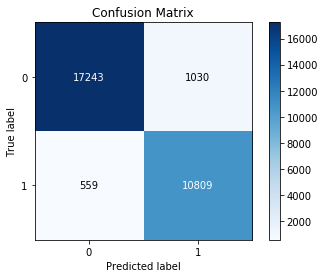

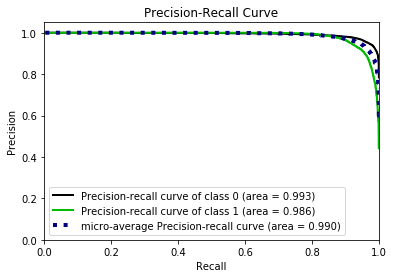

In [122]:
# Define the algorithm we want to use for our model
clf = LogisticRegression(class_weight=class_weights_dict, random_state=42, solver='lbfgs', max_iter=2000)
 
# Train the model
clf.fit(X_train, y_train)
 
# Create predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
 
# Print results
print("Predicted clicks (test set):", sum(y_pred))
print("Sum of predicted click probabilities (aka xG):", "{0:.2f}".format(sum(y_pred_prob[:,1])))
print("Actual clicks (test set):", sum(y_test))
print('')
print(metrics.classification_report(y_test, y_pred))
 
# Plot results
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
skplt.metrics.plot_precision_recall(y_test, y_pred_prob)
plt.show()

Looks like the classifier is overfitting, even with weighted adjustments.

### Upsampling

In [123]:
# Separate input features and target
y = df_train.click_target
X = df_train.drop(['click_target', 'Clicks'], axis=1)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    shuffle=True)

In [124]:
from sklearn.utils import resample
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

In [125]:
# separate minority and majority classes
not_clicked = X[X.click_target==0]
clicked = X[X.click_target==1]

# up sample minority
clicked_upsampled = resample(clicked,
                          replace=True, # sample with replacement
                          n_samples=len(not_clicked), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_clicked, clicked_upsampled])

# check new class counts
upsampled.click_target.value_counts()

1    53668
0    53668
Name: click_target, dtype: int64

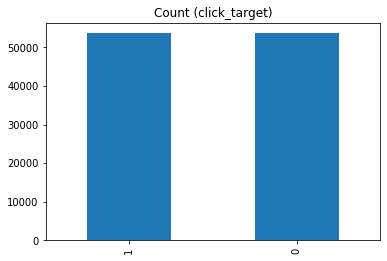

In [98]:
upsampled.click_target.value_counts().plot(kind='bar', title='Count (click_target)');

In [99]:
upsampled.size

3005408

In [126]:
# Scale X to be between 0 and 1 (can speed up processing and help with accuracy)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_up = scaler.fit_transform(X_train_up)
X_test_up = scaler.fit_transform(X_test_up)

Predicted clicks (test set): 29640
Sum of predicted click probabilities (aka xG): 29639.80
Actual clicks (test set): 11368

              precision    recall  f1-score   support

           0       1.00      0.00      0.00     18273
           1       0.38      1.00      0.55     11368

    accuracy                           0.38     29641
   macro avg       0.69      0.50      0.28     29641
weighted avg       0.76      0.38      0.21     29641



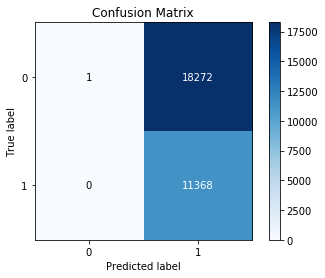

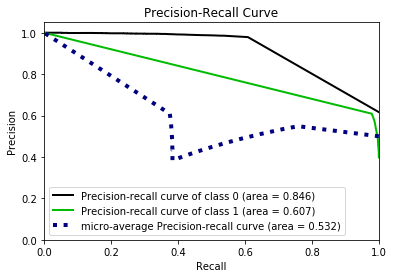

In [128]:
# Define the algorithm we want to use for our model
clf = LogisticRegression(random_state=42, solver='lbfgs', max_iter=2000)
 
# Train the model
clf.fit(X_train_up, y_train_up)
 
# Create predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
 
# Print results
print("Predicted clicks (test set):", sum(y_pred))
print("Sum of predicted click probabilities (aka xG):", "{0:.2f}".format(sum(y_pred_prob[:,1])))
print("Actual clicks (test set):", sum(y_test))
print('')
print(metrics.classification_report(y_test, y_pred))
 
# Plot results
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
skplt.metrics.plot_precision_recall(y_test, y_pred_prob)
plt.show()

### SMOTE Resampling

In [129]:
# Separate input features and target
y = df_train.click_target
X = df_train.drop(['click_target', 'Clicks'], axis=1)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    shuffle=True)

In [147]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))
get_class_dist(data=y_train_res, name='y_train_res')

Before OverSampling, counts of label '1': 35254
Before OverSampling, counts of label '0': 53668 

After OverSampling, the shape of train_X: (107336, 27)
After OverSampling, the shape of train_y: (107336,) 

After OverSampling, counts of label '1': 53668
After OverSampling, counts of label '0': 53668 

107336 total examples in y_train_res
class 0: 53668 examples, 50.00%
class 1: 53668 examples, 50.00%



In [131]:
# create plotting function
def plot_2d_space(X, y, label='click_target'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, alpha=0.3
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

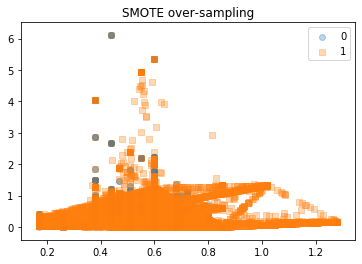

In [132]:
# plot the new resampling
plot_2d_space(X_train_res, y_train_res, 'SMOTE over-sampling')

In [171]:
# Define the algorithm we want to use for our model
clf = LogisticRegression(random_state=42, solver='lbfgs', max_iter=2000)

Predicted clicks (test set): 11062
Sum of predicted click probabilities (aka xG): 11528.23
Actual clicks (test set): 11368

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18273
           1       1.00      0.97      0.98     11368

    accuracy                           0.99     29641
   macro avg       0.99      0.98      0.99     29641
weighted avg       0.99      0.99      0.99     29641



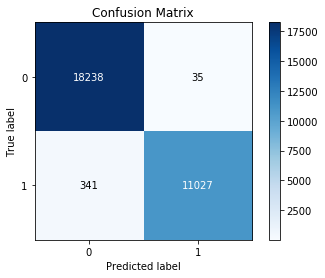

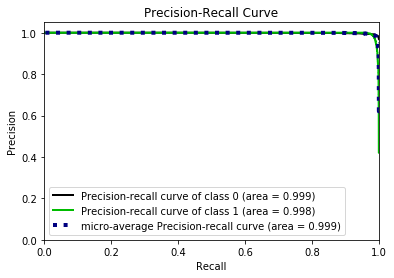

In [134]:
 
# Train the model
clf.fit(X_train_sm, y_train_sm)
 
# Create predictions
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
 
# Print results
print("Predicted clicks (test set):", sum(y_pred))
print("Sum of predicted click probabilities (aka xG):", "{0:.2f}".format(sum(y_pred_prob[:,1])))
print("Actual clicks (test set):", sum(y_test))
print('')
print(metrics.classification_report(y_test, y_pred))
 
# Plot results
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
skplt.metrics.plot_precision_recall(y_test, y_pred_prob)
plt.show()

# Principal Component Analysis - Identifying Clicks vs Non-Clicks

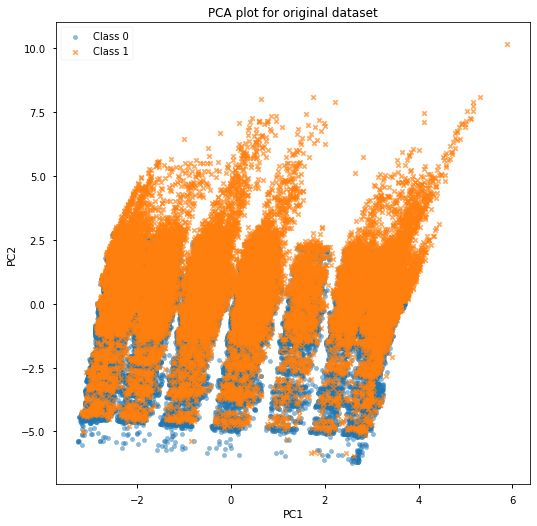

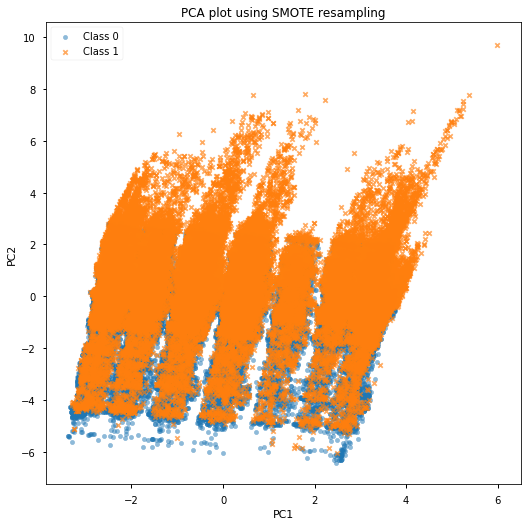

In [137]:
def pca_plot(X, y, title):
    """via https://github.com/wangz10/class_imbalance/blob/master/Main.ipynb"""
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components = 2)
    X_pc = pca.fit_transform(X)
     
    plt.style.use('seaborn-notebook')
    fig, ax = plt.subplots(figsize=(8.5, 8.5))
    mask = y==0
    ax.scatter(X_pc[mask, 0], X_pc[mask, 1], color='#1f77b4', marker='o', label='Class 0', alpha=0.5, s=20)
    ax.scatter(X_pc[~mask, 0], X_pc[~mask, 1], color='#ff7f0e', marker='x', label='Class 1', alpha=0.65, s=20)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(loc='best')
    plt.title(title);
    return
 
pca_plot(X_train, y_train, title='PCA plot for original dataset')
pca_plot(X_train_sm, y_train_sm, title='PCA plot using SMOTE resampling')

# Cross Validation

In [151]:
# Define a function to plot barplot comparisons of models
def barplot_comparison(df, x='name', y1='mcc', y2='brier_loss', figsize=(18, 8)):
    sns.set(style='white')

    f, axs = plt.subplots(ncols=2, figsize=figsize, sharey=False)
    
    # Plot bars
    sns.barplot(x=x, y=y1, data=df, palette='muted', ax=axs[0])
    sns.barplot(x=x, y=y2, data=df, palette='muted', ax=axs[1])

    # Tweak the visual presentation
    axs[0].yaxis.grid(True)
    axs[0].set(xlabel="", ylim=(min(df[y1]-0.02),max(df[y1]+0.02)))
    axs[1].yaxis.grid(True)
    axs[1].set(xlabel="", ylim=(min(df[y2]-0.02),max(df[y2]+0.02)))
    sns.despine(trim=True, left=True);
    
    return

# Define a function to plot boxplot comparisons of models
def boxplot_comparison(df, x='name', y1='mcc', y2='brier_loss', figsize=(18, 8)):
    sns.set(style='white')

    f, axs = plt.subplots(ncols=2, figsize=figsize, sharey=False)

    # Plot boxes
    sns.boxplot(x=x, y=y1, data=df,
                whis='range', palette='muted', ax=axs[0])
    sns.boxplot(x=x, y=y2, data=df,
                whis='range', palette='muted', ax=axs[1])

    # Add in points to show each observation
    sns.swarmplot(x=x, y=y1, data=df,
                  size=4, color='.3', linewidth=0, ax=axs[0])
    sns.swarmplot(x=x, y=y2, data=df,
                  size=4, color='.3', linewidth=0, ax=axs[1])

    # Tweak the visual presentation
    axs[0].yaxis.grid(True)
    axs[0].set(xlabel="", ylim=(min(df[y1]-0.02),max(df[y1]+0.02)))
    axs[1].yaxis.grid(True)
    axs[1].set(xlabel="", ylim=(min(df[y2]-0.02),max(df[y2]+0.02)))
    #axs[1].set_ylim(axs[1].get_ylim()[::-1])
    sns.despine(trim=True, left=True);
    
    return

# Define a function to run stratified k-fold cross-validation and return scores for different models
# If resampling is set, the model will resample within each fold of the cross-validation
def check_model(model, resampling, calibrate, X=X, y=y, k=5, print_res=True, plot_pca=False, random_state=42):
    
    # Convert inputs to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Define the cross-validation parameters
    # Common values of k are 5 and 10, as these have been shown experimentally to produce the best results
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    
    # Create lists to save results to
    mcc = []
    brier = []
    actual_clicks = []
    pred_clicks = []
    model_name = model.__class__.__name__

    # Create training and test data using cross validation and fit model for each fold
    for ii, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if resampling == None:
            res = 'no'
        else:
            X_train, y_train = resampling.fit_resample(X_train, y_train)
            res = resampling.__class__.__name__

        # Calibrate model if necessary
        if calibrate == None:
            calibrated_probs = 'uncalibrated probabilities'
            model.fit(X_train, y_train)
        else:
            model = CalibratedClassifierCV(model, cv=2, method=calibrate)
            model.fit(X_train, y_train)
            calibrated_probs = '%s calibration' % calibrate    
            
        y_pred = model.predict(X_valid)
        y_pred_proba = model.predict_proba(X_valid)[:,1]
        
        # Calculate mcc score, brier_loss and sum of predicted goal probabilities
        actual_clicks.append(sum(y_valid))
        pred_clicks.append(sum(y_pred_proba))
        mcc.append(matthews_corrcoef(y_valid, y_pred))
        brier.append(brier_score_loss(y_valid, y_pred_proba))
        
        if plot_pca == True and ii == 0:
            pca_plot(X_train, y_train, title='%s with %s resampling (1st fold)'
              % (model_name, res))
        else: pass
    
    # Save the results to a dataframe
    df = pd.DataFrame()
    df['model'] = model_name
    df['resampling'] = res
    df['mcc'] = mcc
    df['brier_loss'] = brier
    df['actual_clicks'] = actual_clicks
    df['predicted_clicks'] = pred_clicks
    df['clicks_diff'] = abs(df['actual_clicks'] - df['predicted_clicks'])
    df['calibrated'] = calibrated_probs
    
    # Print a summary of the results if required
    if print_res == True:
        print('Method: %s with %s resampling and %s'
              % (model_name, res, calibrated_probs))
        print('Clicks:', '{0:.2f}'.format(df['actual_clicks'].mean()))
        print('Predicted Clicks:', '{0:.2f}'.format(df['predicted_clicks'].mean()))
        print('MCC:', '{0:.3f}'.format(df['mcc'].mean()))
        print('Brier Loss:', '{0:.3f}'.format(df['brier_loss'].mean()))
        print('')
    else: pass

    return df

Method: RandomForestClassifier with no resampling and uncalibrated probabilities
Goals: 9324.40
Predicted Goals: 9304.16
MCC: 1.000
Brier Loss: 0.000

Method: RandomForestClassifier with SMOTE resampling and uncalibrated probabilities
Goals: 9324.40
Predicted Goals: 9315.59
MCC: 1.000
Brier Loss: 0.000

Method: RandomForestClassifier with TomekLinks resampling and uncalibrated probabilities
Goals: 9324.40
Predicted Goals: 9337.76
MCC: 1.000
Brier Loss: 0.000

Method: RandomForestClassifier with EditedNearestNeighbours resampling and uncalibrated probabilities
Goals: 9324.40
Predicted Goals: 9526.79
MCC: 1.000
Brier Loss: 0.001

Method: RandomForestClassifier with SMOTETomek resampling and uncalibrated probabilities
Goals: 9324.40
Predicted Goals: 9291.75
MCC: 1.000
Brier Loss: 0.000

Method: RandomForestClassifier with SMOTEENN resampling and uncalibrated probabilities
Goals: 9324.40
Predicted Goals: 9151.96
MCC: 1.000
Brier Loss: 0.001



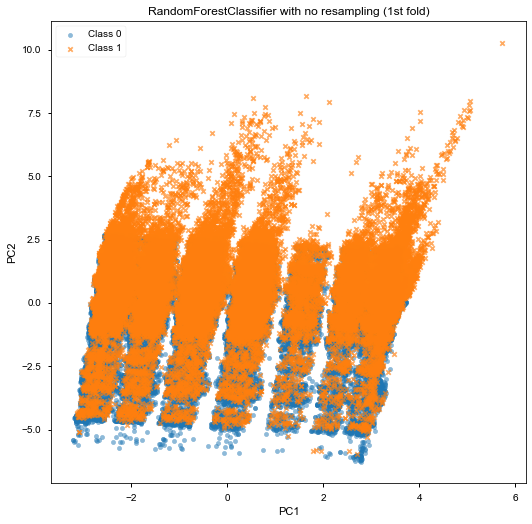

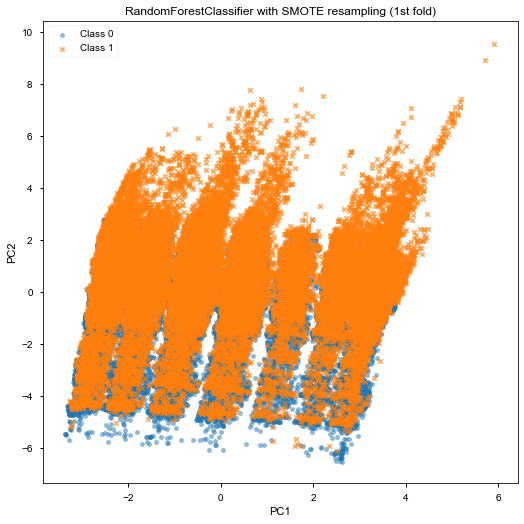

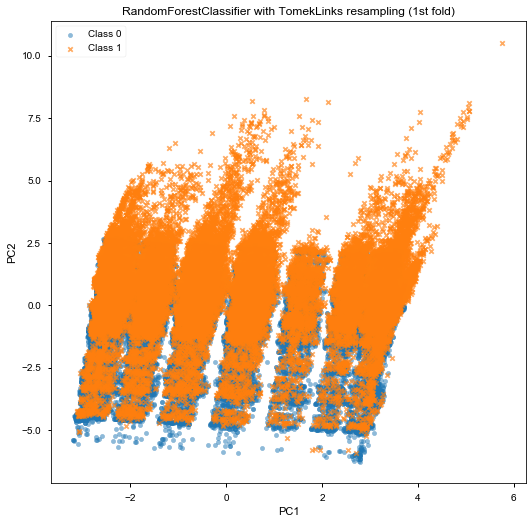

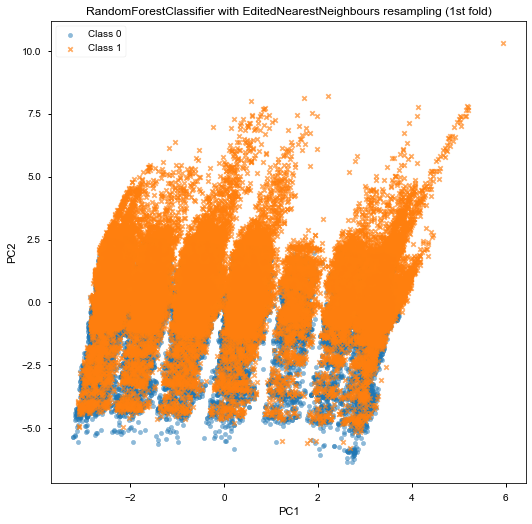

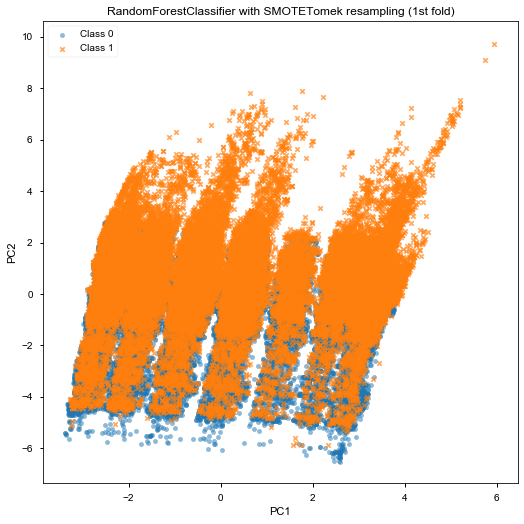

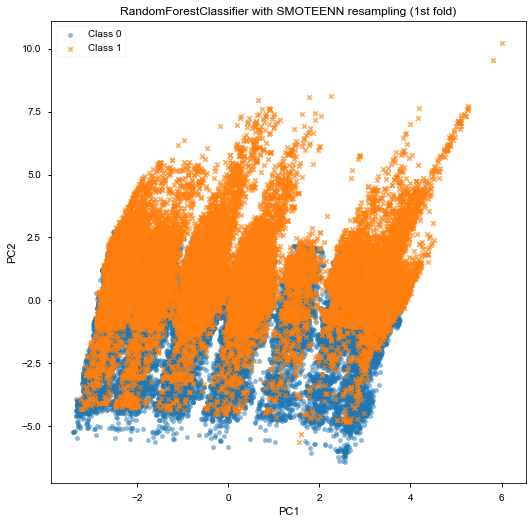

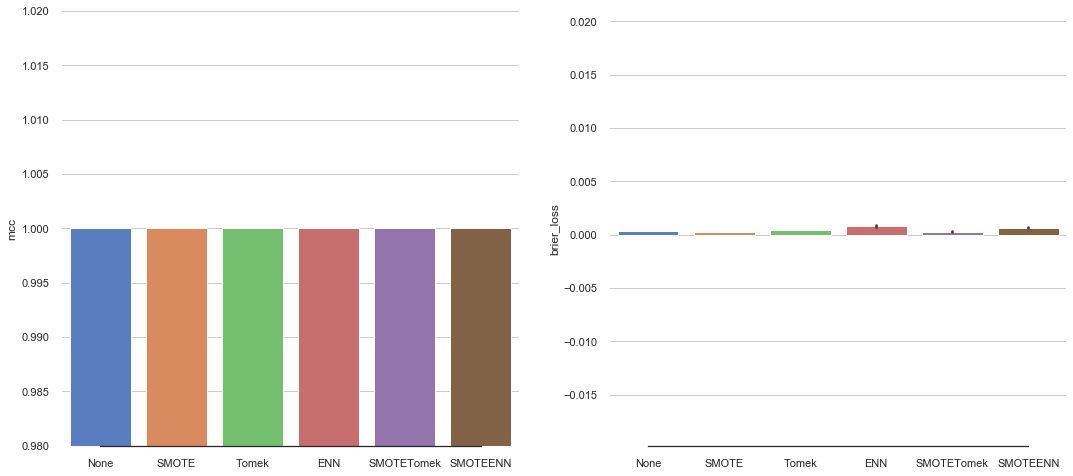

In [150]:
# Try different re-sampling methods with a RandomForestClassifier
# For some reason sklearn and imblearn's default is to use only one processor core
# Most people have multiple cores these days!
# n_jobs=-1 will run the model on all cores in parallel, which can speed things up quite a bit

tomek = TomekLinks(n_jobs=-1, random_state=42)
enn = EditedNearestNeighbours(n_jobs=-1, random_state=42)
smote_tomek = SMOTETomek(tomek=tomek, random_state=42)
smote_enn = SMOTEENN(enn=enn, random_state=42)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

models = []
# Format is name, model, resampling method, probability calibration
models.append(('None', rf, None, None))
models.append(('SMOTE', rf, smote, None))
models.append(('Tomek', rf, tomek, None))
models.append(('ENN', rf, enn, None))
models.append(('SMOTETomek', rf, smote_tomek, None))
models.append(('SMOTEENN', rf, smote_enn, None))

results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = check_model(model, resampling, calibrate, plot_pca=True)
    result['name'] = name
    results_df = results_df.append(result)

# Call boxplot_comparison here instead if you like
barplot_comparison(results_df)

# Feature Selection

Creating some helper fucntions to run models and their accuracies

In [210]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def runModel(model, Xw, y, cv):
    if cv==False:
        model.fit(Xw,y)
        score = model.score(Xw,y)     
    else:
        kfold = KFold(n_splits=10, random_state=42, shuffle=True)
        scores = cross_val_score(model, Xw, y, cv=kfold, scoring='roc_auc')
        score = np.array(scores).mean()
    return(score)

In [211]:
def RFAperf(ranking, modelstr, Xw, y, names, cv=False):
    ranking = list(ranking)
    model = eval(modelstr)
    l = len(ranking)
    
    f_inds = []
    f_names = np.array([])
    f_scorelist = []
    for i in range(1, l+1):
        f_ind = ranking.index(i)
        f_inds.append(f_ind)
        f_names = np.append(f_names, names[f_ind])
        Xin = Xw[:,f_inds]
        score = runModel(model, Xin, y, cv)
        f_scorelist.append((f_names, score))

    return(f_scorelist)

## Recursive Feature Elimination

Ranking function for RFE

In [213]:
def rankRFE(models, Xversions, y, names):
    lnames = len(names)
    FAstr = 'RFE'
    
    modelsData = []
    results = pd.DataFrame([], index=range(1,lnames+1))
    for inputType, Xw in Xversions:
        for model in models:
            modelname = str(model).partition("(")[0]
            rfe = RFE(model, 1)
            # rank RFE results
            rfe.fit(Xw, y)
            ranking = rfe.ranking_
            f_scorelist = RFAperf(ranking, str(model), Xw, y, names, cv=True)
            modelsData.append( (inputType, str(model), FAstr, ranking, f_scorelist) ) 
            f_ranking = [n for r, n in sorted( zip( ranking, names ) )]
            results[modelname[0:3] + FAstr + '-' + inputType[0:2]] = f_ranking
    
    return(modelsData, results)

Create a plotting function to help vizulaise the results of RFE

In [216]:
def plotRFAdata(modelsData, names):
    n = len(modelsData)
    l = len(names)
    
    fig = plt.figure()
    xvals = range(1,l+1)
    colorVec = ['ro', 'go', 'bo', 'co', 'mo', 'yo', 'ko', 'rs', 'gs', 'bs', 'cs', 'ms', 'ys', 'ks']
    for i in range(n):
        modelData = modelsData[i]
        inputType = modelData[0]
        modelstr = modelData[1]
        modelname = modelstr.partition('(')[0]
        FAstr = modelData[2]
        ranking = modelData[3]
        f_scorelist = modelData[4]
        f = np.array(f_scorelist)[:,0]
        s = np.array(f_scorelist)[:,1]
        labelstr = modelname[0:3] + FAstr + '-' + inputType[0:2]
        plt.plot(xvals, s, colorVec[i]+'-',  label=labelstr)
      
    fig.suptitle('Recursive Feature Augmentation Performance')
    plt.ylabel('roc_auc')
    #plt.ylim(ymax=1)
    plt.xlabel('Number of Features')
    plt.xlim(1-0.1,l+0.1)
    plt.legend(loc='lower right', fontsize=10)
    ax = fig.add_subplot(111)
    ax.set_xticks(xvals)
    plt.show()

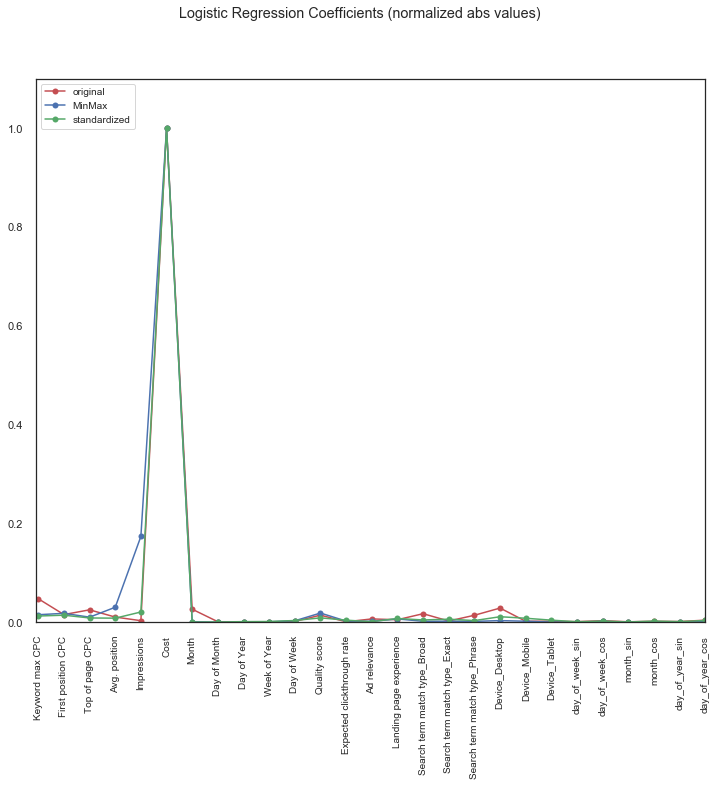

In [220]:
names = list(X_train.columns)
lnames = len(names)

# Regression coefficients for unscaled, scaled and standardized input
coef_or = abs(clf.fit(X_train,y_train).coef_[0])
coef_mm = abs(clf.fit(X_train_mm,y_train).coef_[0])
coef_ss = abs(clf.fit(X_train_ss,y_train).coef_[0])

#f_ranking = zip(*sorted(zip(abs(rfe.estimator_.coef_), names)))[1]
#f_ranking = [n for r, n in sorted( zip( abs(model.coef_), names ) , reverse=True)]

fig = plt.figure(figsize=(12,10))
fig.suptitle('Logistic Regression Coefficients (normalized abs values)')
ax = fig.add_subplot(111)
plt.plot(range(lnames), coef_or/max(coef_or), 'ro-', label='original')
plt.plot(range(lnames), coef_mm/max(coef_mm), 'bo-', label='MinMax')
plt.plot(range(lnames), coef_ss/max(coef_ss), 'go-', label='standardized')
plt.legend(loc='upper left', fontsize=10)
plt.xlim(-0.1, 6.1)
plt.ylim(0, 1.1)
plt.xticks(rotation='vertical')
ax.set_xticks(range(lnames))
ax.set_xticklabels(names, fontsize=10)
#ax.text(0.7, 1.4, 'Ranking: %s '%f_ranking)
plt.show()

In [226]:
FAstr = 'Coeffs'
#rfe = RFE(model, 1)

# prepare test
scaling = [('original', X_train), ('MinMax', X_train_mm), ('standardized', X_train_ss)]

modelsData = []
lnames = len(names)
results = pd.DataFrame([], index=range(1,lnames+1))
for inputType, Xw in scaling:
    
    clf.fit(Xw, y_train)
    
    # extract ranking array from linear coefficients
    ranking = np.zeros((lnames,), dtype=np.int)
    f_r = [n for r, n in sorted(zip(abs(clf.coef_[0]), range(lnames)) , reverse=True)]
    ranking[f_r] = range(1,lnames+1)

    # store all results to modelsData
    modelsData.append((inputType, str(clf), FAstr, ranking)) 
    
    # augment results for table display
    f_ranking = [n for r, n in sorted(zip(abs(clf.coef_[0]), names) , reverse=True)]
    results[FAstr + '-' + inputType[0:2]] = f_ranking
    
resultsCoeffs = results
from IPython.display import display
display(resultsCoeffs)

,Coeffs-or,Coeffs-Mi,Coeffs-st
1,Cost,Cost,Cost
2,Keyword max CPC,Impressions,Impressions
3,Device_Desktop,Avg. position,First position CPC
4,Month,Quality score,Keyword max CPC
5,Top of page CPC,First position CPC,Device_Desktop
6,Search term match type_Broad,Keyword max CPC,Quality score
7,First position CPC,Top of page CPC,Top of page CPC
8,Quality score,Landing page experience,Avg. position
9,Search term match type_Phrase,Device_Desktop,Device_Mobile
10,Avg. position,Day of Week,Landing page experience


### RFEcv

Number of features selected: 12
Test Accuracy 0.9863027563172633


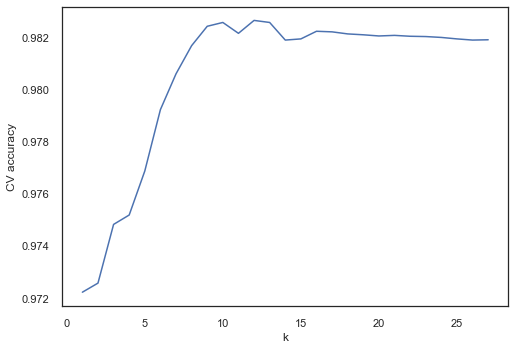

[ True  True  True  True False  True False False False False False  True
 False  True  True False  True False  True  True  True False False False
 False False False]
[ 1  1  1  1  4  1  9 11 12 16  7  1 13  1  1  2  1  3  1  1  1  8  5 15
 10 14  6]


In [164]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
# RFE
rfe_cv = RFECV(estimator=LogisticRegression(random_state=42, solver='lbfgs', max_iter=2000), cv=5, scoring='roc_auc')
rfe_cv = rfe.fit(X_train, y_train)

# Select variables and calulate test accuracy
cols = X_train.columns[rfe_cv.support_]
acc = accuracy_score(y_test, rfe_cv.estimator_.predict(X_test[cols]))
print('Number of features selected: {}'.format(rfe_cv.n_features_))
print('Test Accuracy {}'.format(acc))

# Plot number of features vs CV scores
plt.figure()
plt.xlabel('k')
plt.ylabel('CV accuracy')
plt.plot(np.arange(1, rfe_cv.grid_scores_.size+1), rfe.grid_scores_)
plt.show()
print(rfe_cv.support_)
print(rfe_cv.ranking_)

In [227]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
rfe = RFE(LogisticRegression(random_state=42, solver='lbfgs', max_iter=2000), 12)
rfe = rfe.fit(X_train_mm,y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True False False False False False  True
  True False  True  True False  True  True False False False False False
 False False False]
[ 1  1  1  1  1  1  8 16 15  9  2  1  1  5  1  1  6  1  1  3 14 12  7 13
  4 11 10]


# Evaluation Metrics

Change the performance metric

As we saw above, accuracy is not the best metric to use when evaluating imbalanced datasets as it can be very misleading. Metrics that can provide better insight include:
1. Confusion Matrix: a table showing correct predictions and types of incorrect predictions.

2. Precision: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.
3. Recall: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
4. F1: Score: the weighted average of precision and recall.

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

### F1-score as a fucntion of regularization (penalty) parameter

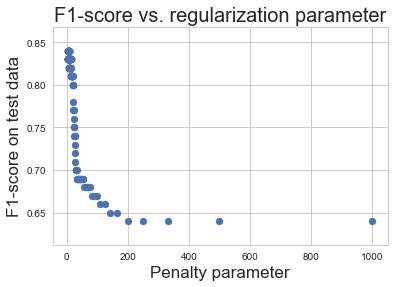

In [193]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
nsimu=201
penalty=[0]*nsimu
logmodel=[0]*nsimu
predictions =[0]*nsimu
class_report = [0]*nsimu
f1=[0]*nsimu
for i in range(1,nsimu):
        logmodel[i] =(LogisticRegression(C=i/1000,tol=1e-4, max_iter=100,n_jobs=4))
        logmodel[i].fit(X_train,y_train)
        predictions[i] = logmodel[i].predict(X_test)
        class_report[i] = classification_report(y_test,predictions[i])
        l=class_report[i].split()
        f1[i] = l[len(l)-2]
        penalty[i]=1000/i

plt.scatter(penalty[1:len(penalty)-2],f1[1:len(f1)-2])
plt.title("F1-score vs. regularization parameter",fontsize=20)
plt.xlabel("Penalty parameter",fontsize=17)
plt.ylabel("F1-score on test data",fontsize=17)
plt.show()

### F1-score as a function of test set size (fraction)

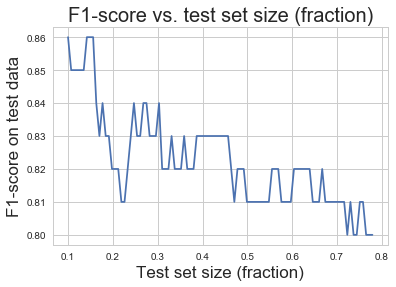

In [197]:
nsimu=101
class_report = [0]*nsimu
f1=[0]*nsimu
test_fraction =[0]*nsimu
for i in range(1,nsimu):
        X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.1+(i-1)*0.007, 
                                                    random_state=111)
        logmodel =(LogisticRegression(C=1,tol=1e-4, max_iter=1000,n_jobs=4))
        logmodel.fit(X_train,y_train)
        predictions = logmodel.predict(X_test)
        class_report[i] = classification_report(y_test,predictions)
        l=class_report[i].split()
        f1[i] = l[len(l)-2]
        test_fraction[i]=0.1+(i-1)*0.007

plt.plot(test_fraction[1:len(test_fraction)-2],f1[1:len(f1)-2])
plt.title("F1-score vs. test set size (fraction)",fontsize=20)
plt.xlabel("Test set size (fraction)",fontsize=17)
plt.ylabel("F1-score on test data",fontsize=17)
plt.show()

# Word2Vec Integration - Using Text based Variables in CLassification

## Add in Word2Vec Data

In [445]:
df_w2vec = pd.concat([df_train, word2vec_data], axis=1)

In [448]:
df_w2vec.columns

Index(['Keyword max CPC', 'First position CPC', 'Top of page CPC',
       'Avg. position', 'Impressions', 'Clicks', 'Cost', 'click_target',
       'Month', 'Day of Month',
       ...
       'day_of_year_sin', 'day_of_year_cos', 'Search keyword', 'Search term',
       'Headline 1', 'Headline 2', 'Description',
       'Expanded text ad description 2', 'Path 1', 'Path 2'],
      dtype='object', length=106)

# Per Campaign Modelling